In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/fraud_dataset.csv')

In [ ]:
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [ ]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Check the distribution of the 'isFraud' column
fraud_counts = df['isFraud'].value_counts()
print("Fraud Distribution:")
print(fraud_counts)

Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


/tmp/ipython-input-2283676680.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='isFraud', data=df, palette=['#3498db', '#e74c3c'])


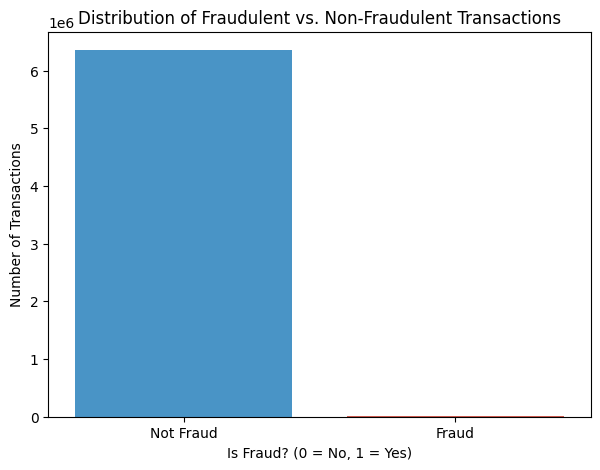

In [ ]:
# Visualize the distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='isFraud', data=df, palette=['#3498db', '#e74c3c'])
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraud? (0 = No, 1 = Yes)')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

In [ ]:
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [ ]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [ ]:
# Let's check the first few rows of our newly processed data
print("Processed Data Head:")
print(df.head())

print("\nShape of the processed data:", df.shape)

Processed Data Head:
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
0             0.0        0          False       False          True   
1             0.0        0          False       False          True   
2             0.0        1          False       False         False   
3             0.0        1           True       False         False   
4             0.0        0          False       False          True   

   type_TRANSFER  
0          False  
1          False  
2           True  
3          False  
4          False  

Shape of the processed data:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:

# --- FIX: Handle missing values in the target variable ---
# First, let's see how many missing values there are in 'isFraud'
print(f"Missing values in 'isFraud' before cleaning: {df['isFraud'].isnull().sum()}")

# Drop rows where 'isFraud' is NaN.
# 'inplace=True' modifies the DataFrame directly.
df.dropna(subset=['isFraud'], inplace=True)

print(f"Missing values in 'isFraud' after cleaning: {df['isFraud'].isnull().sum()}")
# ---------------------------------------------------------


# Define our features (X) and target (y)
# We do this AFTER dropping the NaNs to ensure X and y have the same number of rows
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Split data into 80% training and 20% testing
# 'stratify=y' is VERY important here to keep the same percentage of fraud in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the numerical features
# This brings all our numerical columns to a similar scale, which helps the model learn more effectively.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData splitting and scaling complete!")
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Missing values in 'isFraud' before cleaning: 0
Missing values in 'isFraud' after cleaning: 0

Data splitting and scaling complete!
Training set shape: (5090096, 10)
Testing set shape: (1272524, 10)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
# We use class_weight='balanced' to automatically handle the imbalanced data.
# This tells the model to pay more attention to the fraud cases (the minority class).
model = LogisticRegression(random_state=42, class_weight='balanced')

# Train the model on the scaled training data
print("Starting model training...")
model.fit(X_train_scaled, y_train)

print("Model training complete! 🎉")

Starting model training...
Model training complete! 🎉


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix

In [ ]:
# Make predictions on the test data (which the model has never seen)
y_pred = model.predict(X_test_scaled)

In [ ]:
# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# --- Comprehensive Report ---

# Print a full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

Precision: 0.0238
Recall: 0.9610

Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      0.95      0.97   1270881
    Fraud (1)       0.02      0.96      0.05      1643

     accuracy                           0.95   1272524
    macro avg       0.51      0.96      0.51   1272524
 weighted avg       1.00      0.95      0.97   1272524



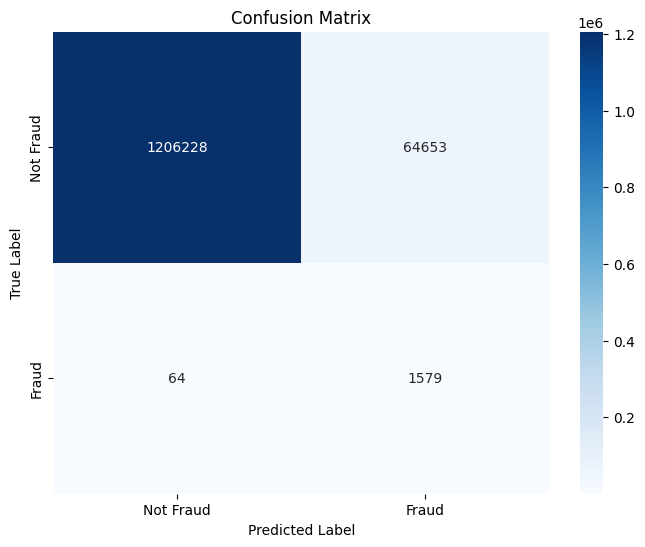

In [ ]:
# --- Visualization ---

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib

# --- Define the filenames ---
model_filename = 'fraud_detection_model.joblib'
scaler_filename = 'scaler.joblib'

# --- Save the model ---
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

# --- Save the scaler ---
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

Model saved to fraud_detection_model.joblib
Scaler saved to scaler.joblib
